# Overview

This notebook steps through non-CNN models for ship identification, including: Logistic Regression, SVM, and Decision Tress.

* From planet data over SF Bay (hosted on Kaggle): https://www.kaggle.com/rhammell/ships-in-satellite-imagery
* 2800 80x80 RGB images labeled ship or no-ship
* 700 ships
* 2100 no ships


# Imports

In [11]:
import random
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import json  
import mpl_toolkits
import os
import pickle
import glob
import re
import itertools
from PIL import Image
import time


import sklearn as sklearn
from sklearn.metrics import confusion_matrix
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier as MLPC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from sklearn import model_selection
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report





import xgboost as xgb
from xgboost import XGBClassifier

import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline



from skimage.feature import hog
from skimage import data, color, exposure
from sklearn import cross_validation

In [2]:
sklearn.__version__

'0.19.1'

# load images

In [3]:
os.listdir("shipsnet_data/shipsnet");

In [4]:
path =r'/Users/mayamidzik/cv/shipsnet/shipsnet_data/shipsnet'

In [5]:
boats = glob.glob(os.path.join(path,'1*.png'))
no_boats = glob.glob(os.path.join(path,'0*.png'))

# Subset boats and create image arrays

In [6]:
#make one large array of data
boats.extend(no_boats)

In [7]:
#create arrays for all image data (contains nested arrays of pixels) and image labels (based on file name) 

image_data = []
image_tag = []

def makeImageDataTagArray(files_list):
    positive = re.compile("/Users/mayamidzik/cv/shipsnet/shipsnet_data/shipsnet/1.*")
    negative = re.compile("/Users/mayamidzik/cv/shipsnet/shipsnet_data/shipsnet/0.*")
    for i in files_list:
        if positive.match(i):
            image_tag.append(1)
        if negative.match(i):
            image_tag.append(0)
        img = Image.open(i)
        arr = np.array(img)
        image_data.append(arr)
        
makeImageDataTagArray(boats)

In [8]:
len(image_tag)

2798

In [9]:
image_data[1].shape

(80, 80, 3)

# Create Transformations of images

## Make rotated set of data

In [16]:
image_data = np.asarray(image_data)
image_tag = np.asarray(image_tag)

In [34]:
image_data = image_data/255

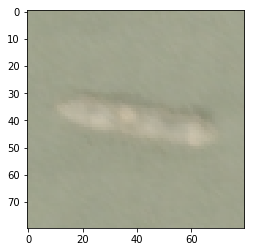

In [35]:
plt.imshow(image_data[1])

In [98]:
datagen = ImageDataGenerator(
        rotation_range=90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True
)  # randomly flip images

datagen.fit(image_data)

In [99]:
image_data[1].shape

(80, 80, 3)

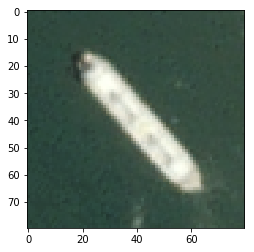

In [105]:
plt.imshow(image_data[4])

In [106]:
for X_batch, y_batch in datagen.flow(image_data, image_tag, batch_size=1000, shuffle = True):
    # Show 9 images
#     for i in range(0, 9):
#         plt.subplot(330 + 1 + i)
#         plt.imshow(X_batch[i])
#         plt.title(y_batch[i])
#     # show the plot
    plt.show()
    break

In [107]:
X_rot = np.concatenate((image_data,X_batch))
y_rot = np.concatenate((image_tag,y_batch))

In [108]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [109]:
X_rot_shuf, y_rot_shuf = unison_shuffled_copies(X_rot,y_rot)

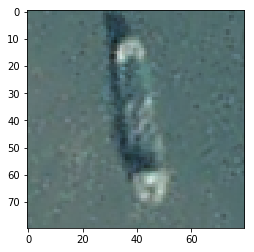

In [121]:
plt.imshow(X_rot_shuf[8])

In [122]:
y_rot_shuf[8]

1

# Test out different models

## Make vectors for modeling & create a test split

In [45]:
#vectorize images for models
def make_vector(image_list):
    vectors = []
    for image in image_list:
        vector = np.ravel(image)
        vectors.append(vector)
    return np.array(vectors)
    

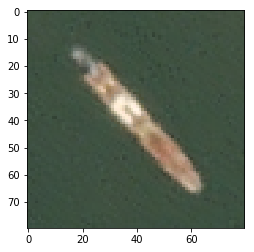

In [94]:
plt.imshow(X_rot[6])

In [46]:
x_vect = make_vector(image_data)
y_vect = np.ravel(image_tag)
x_rot_vect = make_vector(X_rot_shuf)
y_rot_vect = np.ravel(y_rot_shuf)


In [51]:
len(x_vect[1])

19200

In [144]:
#dump to picle for Sliding window & CNN evaluation
pickle.dump(x_vect, open( "x_vect.pkl", "wb" ) )
pickle.dump(y_vect, open( "y_vect.pkl", "wb" ) )
pickle.dump(x_rot_vect, open( "x_rot_vect.pkl", "wb" ) )
pickle.dump(y_rot_vect, open( "y_rot_vect.pkl", "wb" ) )

In [58]:
#split and shuffle
xtrain, xtest, ytrain, ytest = train_test_split(x_vect, y_vect, test_size=0.2, random_state = 1234, stratify = y_vect, shuffle = True)

xrot_train, xrot_test, yrot_train, yrot_test = train_test_split(x_rot_vect, y_rot_vect, test_size=0.2, random_state = 1234, stratify = y_rot_vect, shuffle = True)



In [132]:
(set(yrot_test))

{0, 1}

## helper methods for classifiers

In [70]:
# Generate a confusion matrix plot: 
def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def test_model(model, xtrain, ytrain, xtest, ytest):
    
    start_time = time.time()
    clf = model.fit(xtrain, ytrain)
    train_acc=clf.score(xtrain, ytrain)
    test_acc=clf.score(xtest,ytest)
    print("Training Data Accuracy: %0.2f" %(train_acc))
    print("Test Data Accuracy:     %0.2f" %(test_acc))

    y_true = ytest
    y_pred = clf.predict(xtest)
    y_score=clf.predict_proba(xtest)[:,1]
    fpr, tpr, thresh = roc_curve(ytest, y_score)
    roc_auc = auc(fpr, tpr)
    
    print(roc_auc)
    
    plt.figure()
    # Plotting our Baseline..
    plt.plot([0,1],[0,1])
    plt.plot(fpr,tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')

    conf = confusion_matrix(y_true, y_pred)
    print(conf)

    print ('\n')
    print ("Precision:              %0.2f" %(conf[0, 0] / (conf[0, 0] + conf[1, 0])))
    print ("Recall:                 %0.2f"% (conf[0, 0] / (conf[0, 0] + conf[0, 1])))
    print ("Specificity:              %0.2f" %(conf[1, 1] / (conf[1, 1] + conf[1, 0])))


    cm=confusion_matrix(y_true, y_pred, labels=None)

    plt.figure()
    plot_confusion_matrix(cm)

    print("--- %s seconds ---" % (time.time() - start_time))
    
    return fpr,tpr,thresh

[[399  21]
 [ 19 121]]


Precision:              0.95
Recall:                 0.95
Specificity:              0.86


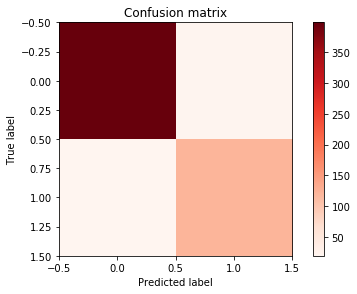

In [137]:
conf = confusion_matrix(y_true, y_pred)
print(conf)

print ('\n')
print ("Precision:              %0.2f" %(conf[0, 0] / (conf[0, 0] + conf[1, 0])))
print ("Recall:                 %0.2f"% (conf[0, 0] / (conf[0, 0] + conf[0, 1])))
print ("Specificity:              %0.2f" %(conf[1, 1] / (conf[1, 1] + conf[1, 0])))


cm=confusion_matrix(y_true, y_pred, labels=None)

plt.figure()
plot_confusion_matrix(cm)


## Test each model individually (Knn, LogReg, SVC, Decision Trees)

Training Data Accuracy: 0.98
Test Data Accuracy:     0.93
[[407  13]
 [ 25 115]]


Precision:              0.94
Recall:                 0.97
Specificity:              0.82
--- 54.06020188331604 seconds ---


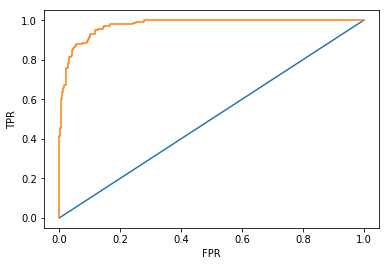

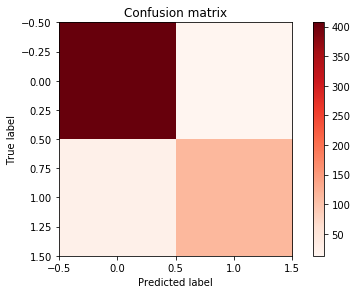

In [77]:
# #test Knn

Knn=  KNeighborsClassifier(n_neighbors=2, n_jobs=-1)

start_time = time.time()
clf = model.fit(xtrain, ytrain)
train_acc=clf.score(xtrain, ytrain)
test_acc=clf.score(xtest,ytest)
print("Training Data Accuracy: %0.2f" %(train_acc))
print("Test Data Accuracy:     %0.2f" %(test_acc))

y_true = ytest
y_pred = clf.predict(xtest)
# y_score=clf.predict_proba(xtest)[:,1]
# fpr, tpr, thresh = roc_curve(ytest, y_score)
# roc_auc = auc(fpr, tpr)

# print(roc_auc)

# plt.figure()
# # Plotting our Baseline..
# plt.plot([0,1],[0,1])
# plt.plot(fpr,tpr)
# plt.xlabel('FPR')
# plt.ylabel('TPR')

conf = confusion_matrix(y_true, y_pred)
print(conf)

print ('\n')
print ("Precision:              %0.2f" %(conf[0, 0] / (conf[0, 0] + conf[1, 0])))
print ("Recall:                 %0.2f"% (conf[0, 0] / (conf[0, 0] + conf[0, 1])))
print ("Specificity:              %0.2f" %(conf[1, 1] / (conf[1, 1] + conf[1, 0])))


cm=confusion_matrix(y_true, y_pred, labels=None)

plt.figure()
plot_confusion_matrix(cm)

print("--- %s seconds ---" % (time.time() - start_time))
    



In [ ]:
#seach for the optimal value of K for KNN
k_range = list(range(1, 10))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k,n_jobs=-1)
    scores = cross_val_score(knn, xtrain, ytrain, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)
#note that k = 2 seems the highest in this range

Training Data Accuracy: 1.00
Test Data Accuracy:     0.93
0.9749829931972789
[[399  21]
 [ 19 121]]


Precision:              0.95
Recall:                 0.95
Specificity:              0.86
--- 21.32716417312622 seconds ---


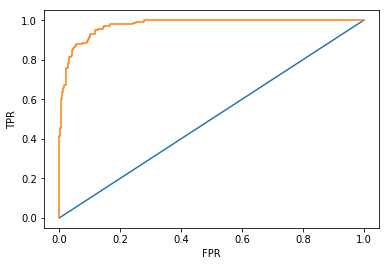

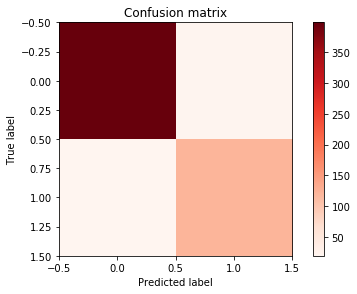

In [141]:
#LogReg
start_time = time.time()

lr = LogisticRegression()
lr_fpr,lr_tpr,lr_thresh = test_model(lr, xtrain, ytrain, xtest, ytest)



Training Data Accuracy: 0.99
Test Data Accuracy:     0.89
0.9445362152476411
[[522  51]
 [ 34 153]]


Precision:              0.94
Recall:                 0.91
Specificity:              0.82
--- 196.5943899154663 seconds ---


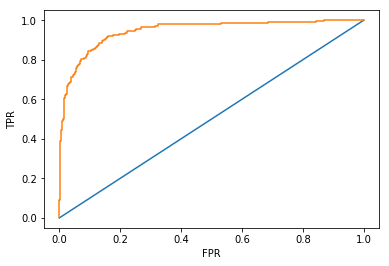

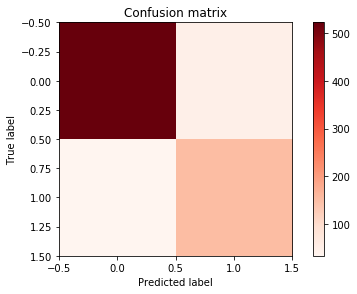

In [143]:
## Logisitic regression with rotation
lr = LogisticRegression()
clf = lr.fit(xrot_train, yrot_train)
train_acc=clf.score(xrot_train, yrot_train)
test_acc=clf.score(xrot_test,yrot_test)
print("Training Data Accuracy: %0.2f" %(train_acc))
print("Test Data Accuracy:     %0.2f" %(test_acc))
y_true = yrot_test
y_pred = clf.predict(xrot_test)
y_score=clf.predict_proba(xrot_test)[:,1]
fpr, tpr, thresh = roc_curve(yrot_test, y_score)
roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

conf = confusion_matrix(y_true, y_pred)
print(conf)

print ('\n')
print ("Precision:              %0.2f" %(conf[0, 0] / (conf[0, 0] + conf[1, 0])))
print ("Recall:                 %0.2f"% (conf[0, 0] / (conf[0, 0] + conf[0, 1])))
print ("Specificity:              %0.2f" %(conf[1, 1] / (conf[1, 1] + conf[1, 0])))


cm=confusion_matrix(y_true, y_pred, labels=None)

plt.figure()
plot_confusion_matrix(cm)

print("--- %s seconds ---" % (time.time() - start_time))


Training Data Accuracy: 0.75
Test Data Accuracy:     0.75
0.8941666666666667
[[420   0]
 [139   1]]


Precision:              0.75
Recall:                 1.00
Specificity:              0.01
--- 441.8910140991211 seconds ---


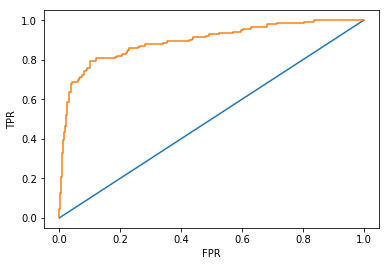

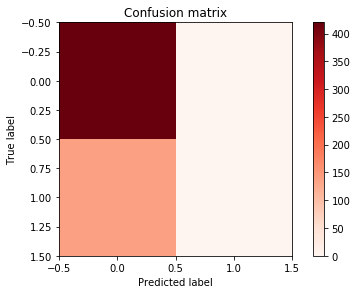

In [74]:
#SVC
svc = SVC(kernel = 'poly',degree = 2,probability=True)
    
svc2_fpr,svc2_tpr,svc2_thresh = test_model(svc, xtrain, ytrain, xtest, ytest)


Training Data Accuracy: 0.75
Test Data Accuracy:     0.75
0.8800850340136055
[[420   0]
 [140   0]]


Precision:              0.75
Recall:                 1.00
Specificity:              0.00
--- 448.50274085998535 seconds ---


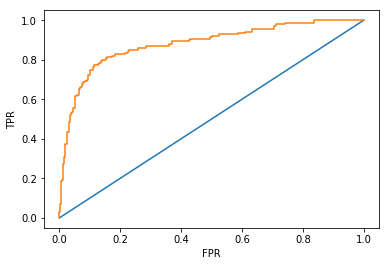

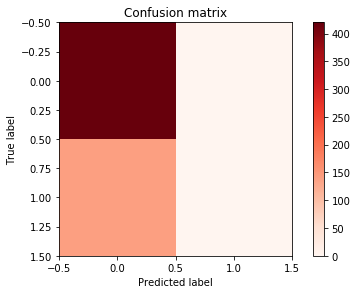

In [75]:
#SVC
svc = SVC(kernel = 'poly',degree = 3,probability=True )
    
svc3_fpr,svc3_tpr,svc3_thresh = test_model(svc, xtrain, ytrain, xtest, ytest)

## Test Decision Tree

Training Data Accuracy: 1.00
Test Data Accuracy:     0.93
[[414   6]
 [ 31 109]]


Precision:              0.93
Recall:                 0.99
Specificity:              0.78
--- 1.4553661346435547 seconds ---


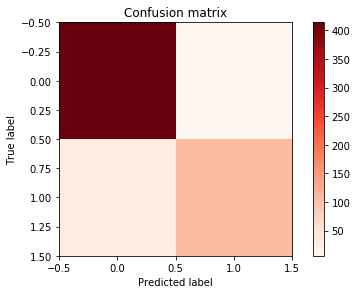

In [28]:
clf = RandomForestClassifier()
test_model(clf, xtrain, ytrain, xtest, ytest)

# Optimize the SVM

In [118]:
#run a grid search to find optimal parameters for SVM
#define hyperparameters
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
tuned_parameters = [{'kernel': ['rbf'], 'gamma': gammas,
                     'C': Cs},
                    {'kernel': ['linear'], 'C': Cs},
                   {'kernel': ['poly'], 'degree':[2,3,4], 'gamma': gammas,
                     'C': Cs}]

In [113]:
#code adampted from sklearn documentation here: 
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(xtrain, ytrain)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    with open('gridResults.pkl', 'wb') as picklefile:
        pickle.dump(clf, picklefile)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = ytest, clf.predict(xtest)
    print(classification_report(y_true, y_pred))
    print()


# Tuning hyper-parameters for precision



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classificatio

KeyboardInterrupt: 